Recognize whether an image of a hand- written digit and a recording of a spoken digit refer to the same or different number

In [1]:
#Libraries Import
import numpy as np
from keras.models import Model
from keras import layers
from keras import Input
import matplotlib.pyplot as plt
from keras.layers import concatenate
from keras.layers.core import Dense
from keras.layers.merge import concatenate
from sklearn.model_selection import train_test_split

#For model Visulization
# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

max_len_speak_frames=93
speak_frame_feature=13
img_height=img_width=28

Using TensorFlow backend.


### Data Preprocessing:

In [2]:
# Data set Reading from Dataset Folder.
written_train=np.load('Datasets/written_train.npy',allow_pickle=True)
written_test=np.load('Datasets/written_test.npy',allow_pickle=True)
spoken_train=np.load('Datasets/spoken_train.npy',allow_pickle=True)
spoken_test=np.load('Datasets/spoken_test.npy',allow_pickle=True)
match_train0=np.load('Datasets/match_train.npy',allow_pickle=True)

In [3]:
#category defining, As our match_train consists of False  adn true so we need to convert it to 0 and 1. If its false then 0.
from sklearn.preprocessing import LabelEncoder
labelencoder_y=LabelEncoder()
match_train0=labelencoder_y.fit_transform(match_train0)


Speak data consists of variable length, and is given as an array of shape (N, 13), where N is the number of frames in the recording, and 13 the number of MFCC features. First apply padding operation to make it same length sequence, so that vectorization allows code to efficiently perform the matrix operations on the batch. The pad_sequences() function in the Keras deep learning library can be used to pad variable length sequences.

In [4]:
from keras.preprocessing.sequence import pad_sequences
# truncate sequence
speak_truncated_train= pad_sequences(spoken_train,maxlen=max_len_speak_frames, dtype='float')
speak_truncated_test= pad_sequences(spoken_test,maxlen=max_len_speak_frames, dtype='float')
print ('Pad Spoken data shape :',speak_truncated_train.shape)


# We are converting the image shape to img_height,img_width,1 so that we can use it in conv2 layer.

written_train0=written_train.reshape(written_train.shape[0],img_height,img_width,1)
written_test0=written_test.reshape(written_test.shape[0],img_height,img_width,1)

Pad Spoken data shape : (45000, 93, 13)


### Model Building:
We choose multi model approach with lstm and Cnn based models used for speak and image respectively. And concatenated the both model output then apply binary cross entropy loss 

In [7]:
# a single input layer 
input1 =Input(shape=(max_len_speak_frames, speak_frame_feature))
# x1 =layers.LSTM(40, activation="relu", dropout=0.25, recurrent_dropout=0.25)(input1)

x1 =layers.CuDNNLSTM(50)(input1)
x1=layers.BatchNormalization()(x1)
x1=layers.Activation('relu')(x1)
x1 =layers.Dropout(0.2)(x1)




x1 =layers.Dense(256)(x1)
x1=layers.BatchNormalization()(x1)
x1=layers.Activation('relu')(x1)
x1 =layers.Dropout(0.3)(x1)
x1 =layers.Dense(64, activation="relu")(x1)



input2 = Input(shape=(img_height,img_width,1))
x2 =layers.Conv2D(16, kernel_size=(5, 5))(input2)
x2=layers.BatchNormalization()(x2)
x2=layers.Activation('relu')(x2)
x2 =layers.Dropout(0.1)(x2)

x2 =layers.Conv2D(32, kernel_size=(5, 5), activation='relu')(x2)
x2=layers.BatchNormalization()(x2)
x2=layers.Activation('relu')(x2)
x2 =layers.MaxPooling2D(pool_size=(2, 2))(x2)

x2 =layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(x2)
x2=layers.BatchNormalization()(x2)
x2=layers.Activation('relu')(x2)
x2 =layers.MaxPooling2D(pool_size=(2, 2))(x2)


x2 =layers.Flatten()(x2)
x2=layers.BatchNormalization()(x2)
x2 =layers.Dropout(0.5)(x2)
x2 =layers.Dense(64, activation="relu")(x2)



concatenated = layers.concatenate([x1, x2], axis=-1)
concatenated=layers.BatchNormalization()(concatenated)
concatenated =layers.Dropout(0.5)(concatenated)
concatenated =layers.Dense(64, activation="relu")(concatenated)

# output layer
predictions = Dense(1, activation='sigmoid')(concatenated)

# At model instantiation, we specify the two inputs and the output:
model = Model([input1, input2], predictions)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 24, 16)   416         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 24, 24, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 24, 24, 16)   0           batch_normalization_5[0][0]      
__________________________________________________________________________________________________
dropout_5 

In [ ]:
## For saving model image but required Graphviz software.
# from keras.utils import plot_model
# plot_model(model, to_file='modelssss.png',show_layer_names=False)

### Model Training:

In [8]:
#class_weight=class_weights,
val_acc=[]
acc=[]
loss=[]
val_loss=[]

for i in range(20):
    ## to solve class imbalance problem we choose random almost equal length of data. different data sample for every for loop iteration.
    new_index=np.unique(np.concatenate(((np.random.randint(0,45000,6000).astype('int')),np.where(match_train0>0)[0].astype('int'))))
    
    # new data sample train test spliting
    spoken_train,spoken_test,written_train,written_test,match_train,match_test=train_test_split(speak_truncated_train[new_index],written_train0[new_index],match_train0[new_index],test_size=0.2,random_state=0)
    hist=model.fit([spoken_train,written_train], match_train, epochs=20,batch_size=512, validation_data=([spoken_test,written_test],match_test))
    
    # accuracy and loss saving for all epochs.
    acc=acc+hist.history['acc']
    val_acc=val_acc+hist.history['val_acc']
    loss=loss+hist.history['loss']
    val_loss=val_loss+hist.history['val_loss']

Train on 7652 samples, validate on 1914 samples
Epoch 1/20
7652/7652 [==============================] - 10s 1ms/step - loss: 0.9433 - acc: 0.4950 - val_loss: 0.7139 - val_acc: 0.5052
Epoch 2/20
7652/7652 [==============================] - 1s 143us/step - loss: 0.7682 - acc: 0.5199 - val_loss: 0.7153 - val_acc: 0.5313
Epoch 3/20
7652/7652 [==============================] - 1s 143us/step - loss: 0.7412 - acc: 0.5212 - val_loss: 0.6834 - val_acc: 0.5643
Epoch 4/20
7652/7652 [==============================] - 1s 143us/step - loss: 0.7144 - acc: 0.5397 - val_loss: 0.6582 - val_acc: 0.5825
Epoch 5/20
7652/7652 [==============================] - 1s 146us/step - loss: 0.7036 - acc: 0.5544 - val_loss: 0.6373 - val_acc: 0.6207
Epoch 6/20
7652/7652 [==============================] - 1s 146us/step - loss: 0.6787 - acc: 0.5762 - val_loss: 0.6221 - val_acc: 0.6416
Epoch 7/20
7652/7652 [==============================] - 1s 150us/step - loss: 0.6624 - acc: 0.6039 - val_loss: 0.6016 - val_acc: 0.6698
E

Epoch 20/20
7660/7660 [==============================] - 1s 147us/step - loss: 0.2362 - acc: 0.9090 - val_loss: 0.2168 - val_acc: 0.9233
Train on 7664 samples, validate on 1916 samples
Epoch 1/20
7664/7664 [==============================] - 1s 158us/step - loss: 0.2522 - acc: 0.9012 - val_loss: 0.1891 - val_acc: 0.9264
Epoch 2/20
7664/7664 [==============================] - 1s 142us/step - loss: 0.2438 - acc: 0.9036 - val_loss: 0.1873 - val_acc: 0.9264
Epoch 3/20
7664/7664 [==============================] - 1s 141us/step - loss: 0.2406 - acc: 0.9034 - val_loss: 0.1890 - val_acc: 0.9280
Epoch 4/20
7664/7664 [==============================] - 1s 142us/step - loss: 0.2427 - acc: 0.9034 - val_loss: 0.1824 - val_acc: 0.9295
Epoch 5/20
7664/7664 [==============================] - 1s 149us/step - loss: 0.2303 - acc: 0.9113 - val_loss: 0.1818 - val_acc: 0.9280
Epoch 6/20
7664/7664 [==============================] - 1s 142us/step - loss: 0.2193 - acc: 0.9161 - val_loss: 0.1812 - val_acc: 0.9269

Epoch 19/20
7649/7649 [==============================] - 1s 145us/step - loss: 0.0810 - acc: 0.9711 - val_loss: 0.0623 - val_acc: 0.9807
Epoch 20/20
7649/7649 [==============================] - 1s 145us/step - loss: 0.0843 - acc: 0.9703 - val_loss: 0.0602 - val_acc: 0.9801
Train on 7672 samples, validate on 1918 samples
Epoch 1/20
7672/7672 [==============================] - 1s 163us/step - loss: 0.0977 - acc: 0.9668 - val_loss: 0.0308 - val_acc: 0.9896
Epoch 2/20
7672/7672 [==============================] - 1s 145us/step - loss: 0.0965 - acc: 0.9642 - val_loss: 0.0492 - val_acc: 0.9844
Epoch 3/20
7672/7672 [==============================] - 1s 142us/step - loss: 0.0957 - acc: 0.9639 - val_loss: 0.0482 - val_acc: 0.9844
Epoch 4/20
7672/7672 [==============================] - 1s 145us/step - loss: 0.0891 - acc: 0.9665 - val_loss: 0.0421 - val_acc: 0.9828
Epoch 5/20
7672/7672 [==============================] - 1s 143us/step - loss: 0.0862 - acc: 0.9688 - val_loss: 0.0456 - val_acc: 0.981

Epoch 18/20
7695/7695 [==============================] - 1s 142us/step - loss: 0.0598 - acc: 0.9793 - val_loss: 0.0344 - val_acc: 0.9865
Epoch 19/20
7695/7695 [==============================] - 1s 144us/step - loss: 0.0714 - acc: 0.9732 - val_loss: 0.0984 - val_acc: 0.9652
Epoch 20/20
7695/7695 [==============================] - 1s 143us/step - loss: 0.0738 - acc: 0.9717 - val_loss: 0.0573 - val_acc: 0.9813
Train on 7684 samples, validate on 1921 samples
Epoch 1/20
7684/7684 [==============================] - 1s 149us/step - loss: 0.0848 - acc: 0.9667 - val_loss: 0.1020 - val_acc: 0.9672
Epoch 2/20
7684/7684 [==============================] - 1s 144us/step - loss: 0.1740 - acc: 0.9396 - val_loss: 0.5488 - val_acc: 0.8204
Epoch 3/20
7684/7684 [==============================] - 1s 144us/step - loss: 0.2518 - acc: 0.9103 - val_loss: 0.5081 - val_acc: 0.8417
Epoch 4/20
7684/7684 [==============================] - 1s 144us/step - loss: 0.2432 - acc: 0.9094 - val_loss: 0.4079 - val_acc: 0.87

Epoch 17/20
7714/7714 [==============================] - 1s 154us/step - loss: 0.0641 - acc: 0.9808 - val_loss: 0.0373 - val_acc: 0.9922
Epoch 18/20
7714/7714 [==============================] - 1s 151us/step - loss: 0.0617 - acc: 0.9806 - val_loss: 0.0425 - val_acc: 0.9902
Epoch 19/20
7714/7714 [==============================] - 1s 151us/step - loss: 0.0591 - acc: 0.9793 - val_loss: 0.0407 - val_acc: 0.9912
Epoch 20/20
7714/7714 [==============================] - 1s 148us/step - loss: 0.0584 - acc: 0.9790 - val_loss: 0.0388 - val_acc: 0.9912
Train on 7652 samples, validate on 1914 samples
Epoch 1/20
7652/7652 [==============================] - 1s 141us/step - loss: 0.0695 - acc: 0.9773 - val_loss: 0.0195 - val_acc: 0.9937
Epoch 2/20
7652/7652 [==============================] - 1s 144us/step - loss: 0.0681 - acc: 0.9754 - val_loss: 0.0181 - val_acc: 0.9948
Epoch 3/20
7652/7652 [==============================] - 1s 143us/step - loss: 0.0630 - acc: 0.9788 - val_loss: 0.0184 - val_acc: 0.9

Epoch 16/20
7675/7675 [==============================] - 1s 139us/step - loss: 0.0347 - acc: 0.9884 - val_loss: 0.0197 - val_acc: 0.9932
Epoch 17/20
7675/7675 [==============================] - 1s 140us/step - loss: 0.0359 - acc: 0.9878 - val_loss: 0.0182 - val_acc: 0.9927
Epoch 18/20
7675/7675 [==============================] - 1s 139us/step - loss: 0.0394 - acc: 0.9863 - val_loss: 0.0170 - val_acc: 0.9927
Epoch 19/20
7675/7675 [==============================] - 1s 138us/step - loss: 0.0376 - acc: 0.9884 - val_loss: 0.0170 - val_acc: 0.9937
Epoch 20/20
7675/7675 [==============================] - 1s 139us/step - loss: 0.0326 - acc: 0.9881 - val_loss: 0.0176 - val_acc: 0.9932
Train on 7685 samples, validate on 1922 samples
Epoch 1/20
7685/7685 [==============================] - 1s 149us/step - loss: 0.0414 - acc: 0.9856 - val_loss: 0.0139 - val_acc: 0.9964
Epoch 2/20
7685/7685 [==============================] - 1s 142us/step - loss: 0.0504 - acc: 0.9819 - val_loss: 0.0272 - val_acc: 0.

Epoch 15/20
7688/7688 [==============================] - 1s 148us/step - loss: 0.0589 - acc: 0.9813 - val_loss: 0.0145 - val_acc: 0.9953
Epoch 16/20
7688/7688 [==============================] - 1s 148us/step - loss: 0.0556 - acc: 0.9815 - val_loss: 0.0169 - val_acc: 0.9953
Epoch 17/20
7688/7688 [==============================] - 1s 150us/step - loss: 0.0601 - acc: 0.9792 - val_loss: 0.0172 - val_acc: 0.9958
Epoch 18/20
7688/7688 [==============================] - 1s 149us/step - loss: 0.0604 - acc: 0.9788 - val_loss: 0.0356 - val_acc: 0.9896
Epoch 19/20
7688/7688 [==============================] - 1s 147us/step - loss: 0.0711 - acc: 0.9780 - val_loss: 0.0255 - val_acc: 0.9922
Epoch 20/20
7688/7688 [==============================] - 1s 147us/step - loss: 0.0632 - acc: 0.9783 - val_loss: 0.0193 - val_acc: 0.9964
Train on 7656 samples, validate on 1915 samples
Epoch 1/20
7656/7656 [==============================] - 1s 159us/step - loss: 0.0703 - acc: 0.9753 - val_loss: 0.0191 - val_acc: 0

### Model Evaluation

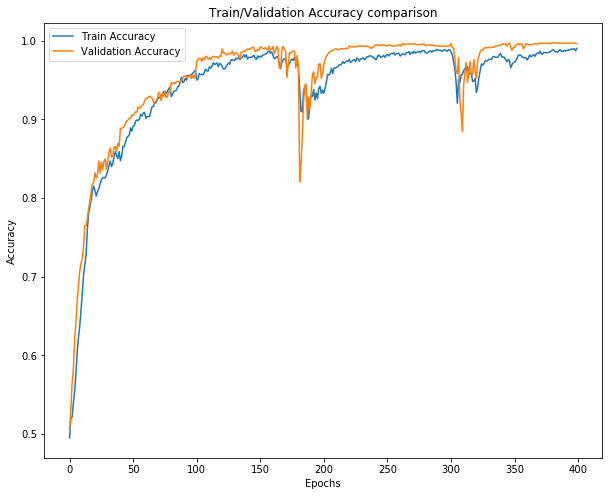

In [9]:
plt.figure(figsize=[10,8])
plt.plot(acc,label='Train Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.title('Train/Validation Accuracy comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Train_Validation_Accuracy_comparison.png')
plt.show()

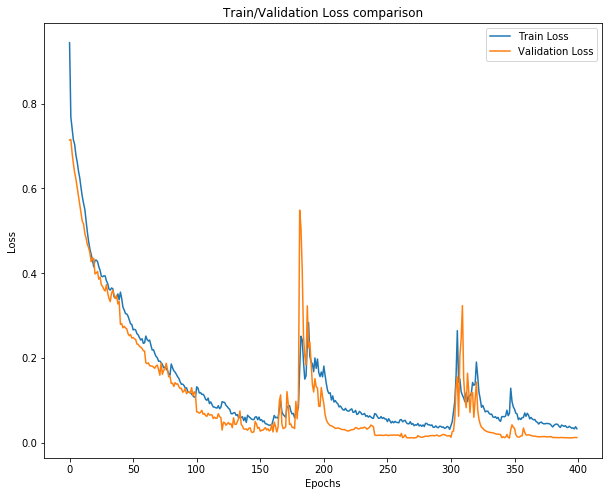

In [10]:
plt.figure(figsize=[10,8])
plt.plot(loss,label='Train Loss')
plt.plot(val_loss,label='Validation Loss')
plt.title('Train/Validation Loss comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Train_Validation_Loss_comparison.png')
plt.show()

In [11]:
print ('Score on last training data [loss,acc]: ',model.evaluate([speak_truncated_train,written_train0], match_train0))
##Confusion matrix prediction on last whole training Dataset.
predicted=model.predict([speak_truncated_train,written_train0])

predicted[predicted>0.5]=1
predicted[predicted<0.51]=0

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(match_train0, predicted)
print ('Confusion Matrix on all training data: ',cm)

45000/45000 [==============================] - 13s 291us/step
Score on last training data [loss,acc]:  [0.018493843168620433, 0.9941777777777778]
Confusion Matrix on all training data:  [[40200   261]
 [    1  4538]]


In [12]:
print ('Score on last test data [loss,acc]: ', model.evaluate([spoken_test,written_test], match_test))

##Confusion matrix prediction on last test Dataset.
predicted=model.predict([spoken_test,written_test])
predicted[predicted>0.5]=1
predicted[predicted<0.51]=0

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(match_test, predicted)
print ('Confusion Matrix on last test data: ',cm)

1918/1918 [==============================] - 1s 305us/step
Score on last test data [loss,acc]:  [0.013051122642822401, 0.9963503649635036]
Confusion Matrix on last test data:  [[1021    6]
 [   1  890]]


In [14]:
import pandas as pd

In [15]:
pd.DataFrame(cm)

,0,1
0,1021,6
1,1,890


In [ ]:
858+19

In [16]:
print ('Prediction on test data and saving output prediction as bolean values in result.npy file.')
test_predicted=model.predict([speak_truncated_test,written_test0])

test_predicted[test_predicted>0.5]=True
test_predicted[test_predicted<0.51]=False

test_predicted=(test_predicted.astype('int')>0).reshape(-1,)

np.save('result.npy',test_predicted,allow_pickle=True)

Prediction on test data and saving output prediction as bolean values in result.npy file.
